In [26]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [27]:
# Convertible bond pricing model (Cox-Ross-Rubinstein method)
def CRR_convertible_bond(S0, F, T, r, k, u, d, p, coupon, conversion_ratio, steps):
    dt = T / steps  # Time step
    discount_factor = np.exp(-(r + k) * dt)  # Discount factor per time step

    # Create the binomial stock price tree
    stock_price_tree = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            stock_price_tree[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price tree (including coupon payments)
    bond_price_tree = np.zeros((steps + 1, steps + 1))
    # Create the conversion probability tree
    conversion_prob_tree = np.zeros((steps + 1, steps + 1))

    # Calculate bond prices and conversion probabilities at maturity
    for j in range(steps + 1):
        stock_price = stock_price_tree[j, steps]
        bond_value_at_maturity = max(conversion_ratio * stock_price, F + coupon)
        bond_price_tree[j, steps] = bond_value_at_maturity
        # If bond is converted at maturity, the conversion probability is 1 if conversion is optimal
        conversion_prob_tree[j, steps] = 1 if conversion_ratio * stock_price > F + coupon else 0

    # Work backward through the tree to calculate the bond price and conversion probabilities at each node
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            stock_price = stock_price_tree[j, i]

            # Holding the bond (with coupon)
            hold_bond_value = discount_factor * (
                p * bond_price_tree[j + 1, i + 1] + (1 - p) * bond_price_tree[j, i + 1]
            ) + coupon
            
            # Conversion option (convert bond to stock) 
            convert_to_stock_value = conversion_ratio * stock_price
            
            # At each node, the bond price is the maximum of holding or converting
            bond_price_tree[j, i] = max(hold_bond_value, convert_to_stock_value)

            # Calculate the conversion probability at each node
            # If the bond is converted at this node, set conversion probability to 1
            if bond_price_tree[j, i] == convert_to_stock_value:
                conversion_prob_tree[j, i] = 1
            else:
                # Otherwise, calculate weighted average of conversion probabilities of next nodes
                conversion_prob_tree[j, i] = (
                    p * conversion_prob_tree[j + 1, i + 1] + (1 - p) * conversion_prob_tree[j, i + 1]
                )

    return stock_price_tree, bond_price_tree, conversion_prob_tree

In [40]:
# Function to plot the binomial tree with symmetry
def plot_binomial_tree(tree, title):
    steps = tree.shape[1] - 1
    G = nx.DiGraph()

    pos = {}
    labels = {}
    
    # Define the horizontal offset to center the nodes at each level
    for i in range(steps + 1):
        # This ensures that the nodes are evenly spaced horizontally for symmetry
        for j in range(i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - (i / 2))  # Adjust vertical position to center the tree
            labels[node] = f"{tree[j, i]:.2f}"

            if i < steps:
                G.add_edge(node, f"{i+1},{j}")
                G.add_edge(node, f"{i+1},{j+1}")

    # Plot
    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()

In [31]:
S0 = 75            # Initial stock price
F = 100            # Face value of the bond
T = 5              # Time to maturity (in years)
r = b = 0.07          # Risk-free rate (5-year treasury)
k = 0.03           # Credit spread (above treasury)
# u = 1.2214       # Up factor
# d = 0.8187       # Down factor
# p = 0.6302       # Risk-neutral probability
coupon = 6         # Coupon payment per year
m = 1              # Conversion ratio (1 bond = 1 stock)
steps = 5          # Number of time steps

In [32]:
# Parameters
sigma = 0.2
dt = 1
u = np.exp(sigma * np.sqrt(dt))        # Up factor
print("Up factor (u):", u)
d = 1/u                                # Down factor
print("Down factor (d):", d)
p = (np.exp(b * dt) - d) / (u - d)     # Risk-neutral probability
print("Risk-neutral probability (p):", p)



Up factor (u): 1.2214027581601699
Down factor (d): 0.8187307530779818
Risk-neutral probability (p): 0.6302336019719996


In [36]:
def calculate_bond_value(m, S0, u, d, r, p, dt):
    # Conversion value
    conversion_value = m * S0
    
    # Holding value (discounted future values)
    holding_value = (
        p * u * np.exp(-r * dt) + (1 - p) * d * np.exp(-r * dt)
    )
    
    # The bond value at the current node is the max of conversion and holding
    bond_value = max(conversion_value, holding_value)
    
    return bond_value

# Calculate the bond value at the current node
Pn_i = calculate_bond_value(m, S0, u, d, r, p, dt)

print("Bond value at current node:", Pn_i)

Bond value at current node: 75


In [37]:
def calculate_conversion_probability(p, u, d):
    # Conversion probability at the current node is a weighted sum of future probabilities
    qn_i = p * u + (1 - p) * d
    return qn_i

# Calculate the conversion probability at the current node
qn_i = calculate_conversion_probability(p, u, d)

print("Conversion probability at current node:", qn_i)


Conversion probability at current node: 1.0725081812542165


In [38]:
def calculate_adjusted_rate(qn_i, rn_i, k):
    # Adjusted rate at the current node
    rn_i = qn_i * rn_i + (1 - qn_i) * (rn_i + k)
    return rn_i

# Calculate the adjusted discount rate at the current node
rn_i = calculate_adjusted_rate(qn_i, r, k)

print("Adjusted rate at current node:", rn_i)


Adjusted rate at current node: 0.06782475456237351


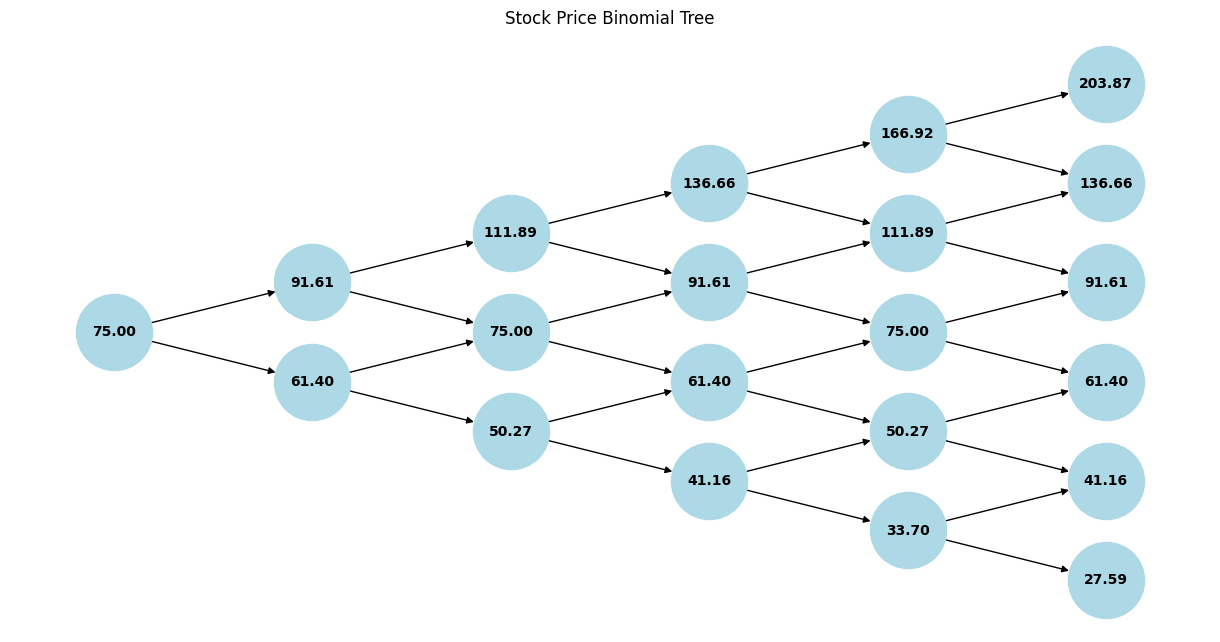

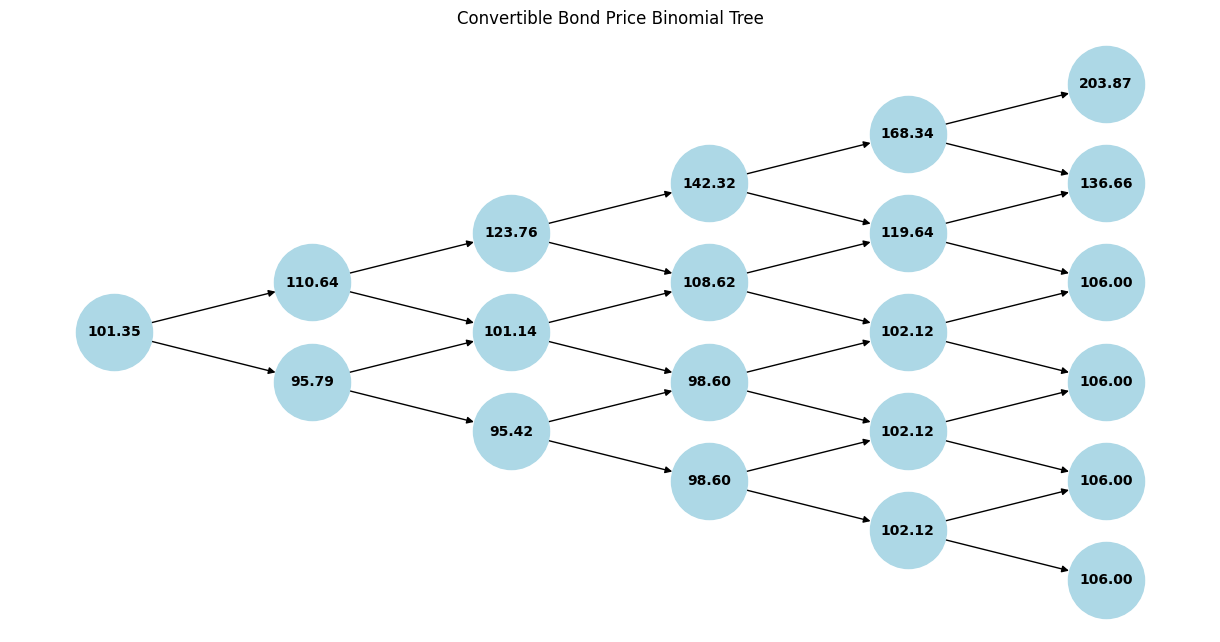

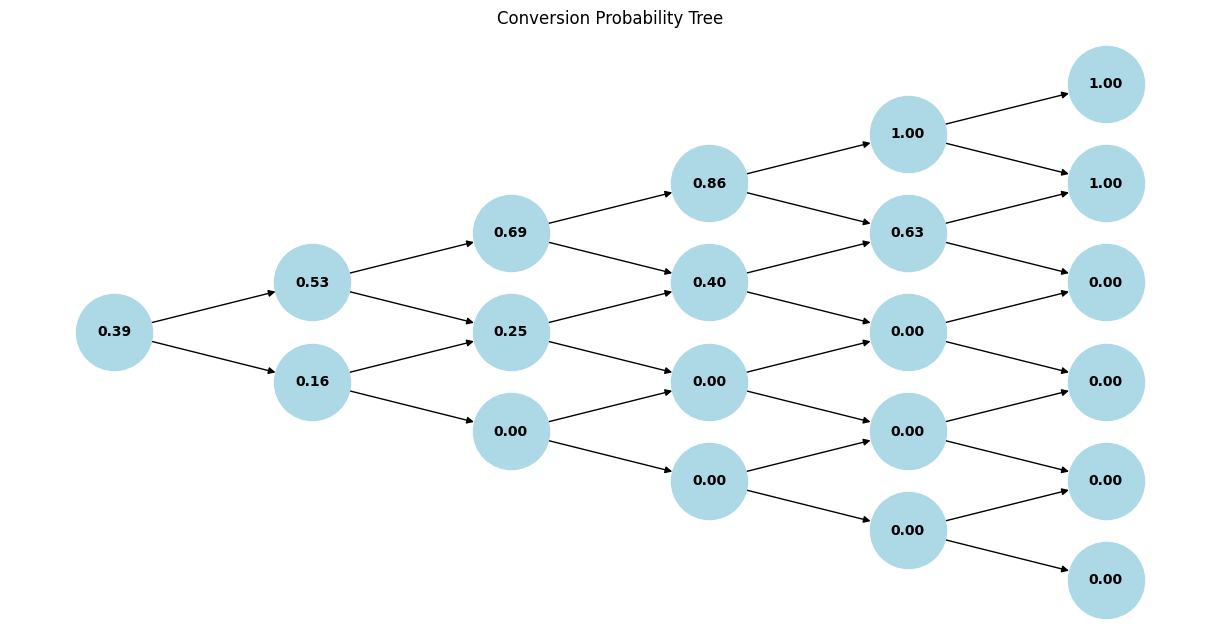

In [41]:
# Calculate the binomial trees for stock prices, bond prices, and conversion probabilities
stock_price_tree, bond_price_tree, conversion_prob_tree = CRR_convertible_bond(S0, F, T, rn_i, k, u, d, p, coupon, m, steps)

# Plot the stock price tree
plot_binomial_tree(stock_price_tree, "Stock Price Binomial Tree")

# Plot the bond price tree
plot_binomial_tree(bond_price_tree, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(conversion_prob_tree, "Conversion Probability Tree")